# Predicting political affiliation with Näive Bayes

The aim is to classify and predict the political affiliation of a person. A bayesian approach is suggested. The model consists on the following steps:

### 1. A vector of values is associated with each person.
The vector consists of all numerical and/or categorical features of that given person. For example, [21, female, college] refers to age, sex, and educational degree. 


### 2. The prior and conditional probabilities were computed:
The prior probability involves, for example, the probability of being democrat: P(democrat). The prior probabilities are stored in the form if a dictionary:

        { 'Democrat': 0.3219895287958115,
          'Independent': 0.43324607329842935,
          'Republican': 0.24476439790575916   }


The conditional probabilities of each feature involves the probability of the feature (for example, women) given democrat or given republican. Conditional probabilities are also stored in the form of a dictionary (numbers represeting the position of the feature in the vector):

        {  'Democrat':  {1: {'Female': 0.568, 'Male': 0.4, 'unknown': 0.008, 'Other': 0.024},
                        {2: {.....}, }
          'Republican': {1: {'Female': 0.465,'Male': 0.497,'Other': 0.026},
                        {2: {.....}, } }
                      

In the case of categorical features, the posterior probability is found by multiplying the prior and the conditional. 


### 3. The posterior probability was computed:
The posterior probability is calculated as the product of the prior and the conditional probability.

        P(democrat|D) = P(D|democrat)*P(democrat)
                        _________________________
                                  P(D)

In the case of numeric features, the **probability density function** was calculated.


A **10-fold cross validation method** was computed to train and test the data and the **accuracy** was calculated. Finally, the results of the classification can be seen in a **confusion matrix**.

### Datasets

1. Political affiliation of a congressperson based on voting records of bills in the U.S. Congress. Each feature take 3 values: yes, no, or abstention (?). The bills' topics include: immigration, religion in schools, foreign aid, education spending, etc. Source of the [dataset](https://www.kaggle.com/devvret/congressional-voting-records).
2. Political affiliation of a person based on features such as income, gender, race, as well as opinions regarding Trump's administration, climate change, federal funding of scientific research, the use of vaccines on children, the total number of books read during last year, among others. Source of the [dataset](https://www.kaggle.com/cardsagainsthumanity/pulse-of-the-nation?select=201709-CAH_PulseOfTheNation.csv).


## Model

In [82]:
import math

class NaiveBayesClassifier:
    
    def __init__(self, filepath, testBucketNum, dataFormat):
        
        totalRows = 0

        # Categorical data
        classesCount = {} # total classes
        attributesCount = {} # total attr per class

        # Numerical data
        numericTotals = {} # {cat1: {col1:x, col2:x}, cat2: { ... }} -> used for mean
        numericValues = {} # {cat1: {col1:[x,x3,x3,x4], cat2:[...] }} -> used for ssd
        
        # format
        self.format = dataFormat.strip().split('\t')
        
        # Probabilities
        self.prior = {}
        self.conditionals = {}

        # 10-fold method 
        for i in range(1,11):
            if i != testBucketNum:
                filename = "%s-%02i" % (filepath, i)
                f = open(filename)
                lines = f.readlines()
                f.close()

                # process training files 
                for line in lines:
                    fields = line.strip().split('\t')
                    attrVector = []
                    numVector = []
                    for i in range(len(fields)):
                        if len(fields) == len(self.format):
                            if self.format[i] == 'num':
                                numVector.append(float(fields[i]))
                            elif self.format[i] == 'attr':
                                attrVector.append(fields[i])
                            elif self.format[i] == 'class':
                                category = fields[i]
                        else:
                            continue
                    # Count row    
                    totalRows += 1 

                    # initialize dictionaries
                    classesCount.setdefault(category,0)
                    attributesCount.setdefault(category,{})
                    numericTotals.setdefault(category, {})
                    numericValues.setdefault(category, {})

                    # count category 
                    classesCount[category] += 1

                    # count attributes of each category
                    col = 0
                    for columnValue in attrVector:
                        col += 1
                        attributesCount[category].setdefault(col, {})
                        attributesCount[category][col].setdefault(columnValue, 0)
                        attributesCount[category][col][columnValue] += 1

                    # count numeric data        
                    col = 0
                    for columnValue in numVector:
                        col += 1
                        numericTotals[category].setdefault(col, 0)
                        numericTotals[category][col] += columnValue
                        numericValues[category].setdefault(col, [])
                        numericValues[category][col].append(columnValue)

        #-----------------------------------#
        #          Probabilities            #
        #-----------------------------------#
        # prior probabilities of the categories
        for key, value in classesCount.items():
            self.prior[key] = value / totalRows 

        # Compute conditional probabilities of the attributes of the categories
        # a) level category
        for k,v in attributesCount.items():
            self.conditionals.setdefault(k,{})
            # b) level column number
            for k2,v2 in v.items(): 
                self.conditionals[k].setdefault(k2,{})
                # Avoid that a zero dominates the calculation. For this, the conditional probability will be adjusted as:
                # the sum of P(attribute|class) + mp divided by the sum of P(class) + m
                # where m is the number of values an attribute can take
                # and p is the probability of the values (assuming uniform probability)
                # Thus if the attribute can take 2 values, m=2 and p=1/2.
                m = len(v2) 
                probability_m = 1 / m 
                # c) level attribute 
                for k3,v3 in v2.items():
                    self.conditionals[k][k2].setdefault(k3,0)
                    #self.conditionals[k][k2][k3] = v3 / classesCount[k]
                    self.conditionals[k][k2][k3] = (v3 + (m*probability_m)) / (classesCount[k] + m)

        self.tmp = attributesCount

        #-----------------------------------#
        #      Mean and standard dev        #
        #-----------------------------------#
        self.means = {}
        self.ssd = {}

        # mean
        for k,v in numericTotals.items():
            self.means.setdefault(k, {})
            for k2,v2 in v.items():
                if v2 != 0:
                    self.means[k][k2] = v2 / classesCount[k]

        # sample standard deviation
        # formula -> sqrt of ( ∑(x-mean)^2 ) / ( n-1 ) 
        for k,v in numericValues.items():
            self.ssd.setdefault(k, {})
            for k2,v2 in v.items(): # where v2 is a list with values
                if v2 != 0:
                    numerator = 0
                    meanValue = self.means[k][k2] # mean of category and column
                    for value in v2:
                        numerator += (value - meanValue)**2
                    v[k2] = 0
                    self.ssd[k][k2] = math.sqrt(numerator / (classesCount[k]-1))

    #-----------------------------------#
    #             Classify              #
    #-----------------------------------#
    def classify(self, attrVector, numVector):
        results = []
        sqrt2pi = math.sqrt(2 * math.pi)
        # for each category
        for k,v in self.prior.items():
            prob = v # prior probability
            # attrVector
            col = 1 
            for attribute in attrVector:
                if not attribute in self.conditionals[k][col]:
                    prob = 0
                else:
                    prob = self.conditionals[k][col][attribute] * prob
                col +=1 
            
            col = 1
            for num in numVector:
                mean = self.means[k][col]
                ssd = self.ssd[k][col]
                # calculate probability density function
                ePart = math.pow(math.e, -(num - mean)**2/(2*ssd**2))
                prob = prob * ((1.0 / (sqrt2pi*ssd)) * ePart)
                col += 1

            results.append((prob, k))

        # return category with the highest probability
        return max(results)[1]

    #-----------------------------------#
    #             testData              #
    #-----------------------------------#
    def testData(self, filepath, testBucketNum):
        filename = "%s-%02i" % (filepath, testBucketNum)
        f = open(filename)
        lines = f.readlines()
        f.close()

        a = [] #actual
        p = [] # predicted
        corrects = 0

        for line in lines:
            fields = line.strip().split('\t')
            attrVector = []
            numVector = []
            classInColumn = -1
            for i in range(len(fields)):
                if len(fields) == len(self.format):
                    if self.format[i] == 'num':
                        numVector.append(float(fields[i]))
                    elif self.format[i] == 'attr':
                        attrVector.append(fields[i])
                    elif self.format[i] == 'class':
                        classInColumn = i
                else:
                    continue
            realClass = fields[classInColumn]
            predictedClass = self.classify(attrVector, numVector)
            if realClass == predictedClass:
                corrects += 1

            a.append(realClass)
            p.append(predictedClass)

        return a, p, corrects

#--------- Outside class -----------#
#-----------------------------------#
#     10-fold cross validation      #
#-----------------------------------#

def tenfold(filepath, dataFormat):
    total_a = [] #list of lists
    total_p = [] #list of lists
    total_corrects = 0
  
    for i in range(1,11):
        classifier = NaiveBayesClassifier(filepath, i, dataFormat)
        a, p, corrects = classifier.testData(filepath, i)
        total_a.append(a)
        total_p.append(p)
        total_corrects += corrects

    actual = [i for l in total_a for i in l] #list reduction
    predicted = [i for l in total_p for i in l] #list reduction

    if len(actual) == len(predicted):
        accuracy = total_corrects/len(actual) *100
        return actual, predicted, accuracy
    else:
        return "Error: number of predictions is different from actual"

## Dataset 1: U.S. Congressional voting records

In [92]:
filepath = "./data/house_votes/hv"
dataFormat = "class\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr"
actual, predicted, accuracy = tenfold(filepath, dataFormat)
accuracy

90.11494252873563

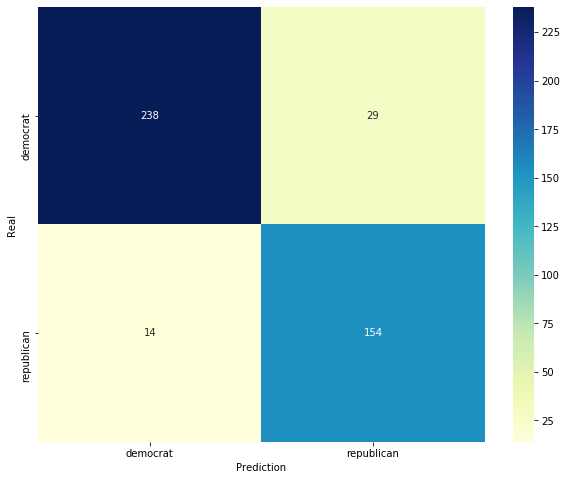

In [84]:
# create confusion matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

y_actual = pd.Series(actual, name='Real')
y_predicted = pd.Series(predicted, name='Prediction')
confusion_matrix = pd.crosstab(y_actual, y_predicted)

fig, ax = plt.subplots(figsize=(10,8))
sn.heatmap(confusion_matrix, annot=True, cmap="YlGnBu",fmt='g')
plt.show()

## Dataset 2: Political affiliation predictor

With an accuracy of 53%, predicting political affiliation is more difficult. The problem is with independents, which are more difficult to predict correctly. If we take a look at the confusion matrix, most of the democrats were correctly labeled as democrats; however, 41% of the people were labeled as democrats when, in reality, they were independent. Interestingly, the model tends to classify an independent as democrat more often than as a republican. 

Some ideas to fix the model: 1) Perform feature selection (some features might have more weight when it comes to predicting democrats and republicans). 2) Take a look at the model without independents.

In [114]:
filepath = "./data/public_opinion/data"
dataFormat = "class\tnum\tattr\tnum\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tnum\tattr\tattr"
actual, predicted, accuracy = tenfold(filepath, dataFormat)

### Accuracy

In [115]:
accuracy

52.8235294117647

### Prior probabilities

In [116]:
testBucketNum = 1
classifier = NaiveBayesClassifier(filepath, testBucketNum, dataFormat)
classifier.prior

{'Democrat': 0.3219895287958115,
 'Independent': 0.43324607329842935,
 'Republican': 0.24476439790575916}

### Conditional probabilities

In [137]:
# P(Female|Democrat)
classifier.conditionals['Democrat'][1]['Female']

0.568

In [118]:
#P(Married|Republican)
classifier.conditionals['Republican'][5]['Married']

0.6269430051813472

In [119]:
#P(Believe that climate change is not real|Republican)
classifier.conditionals['Republican'][7]['NotReal']

0.2670157068062827

In [120]:
#P(Believe that climate change is not real|Democrat)
classifier.conditionals['Democrat'][7]['NotReal']

0.064

### Confusion Matrix

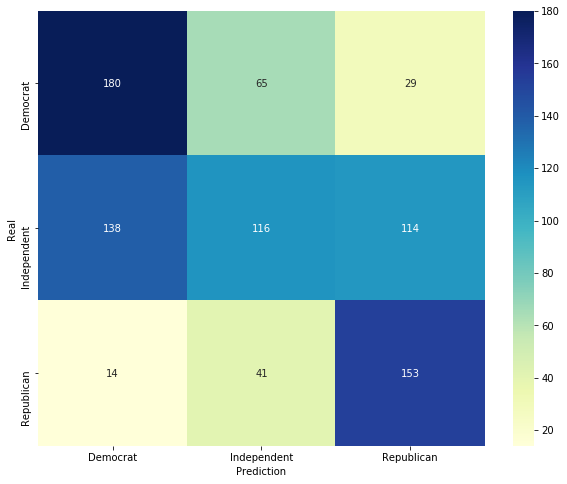

In [121]:
# create confusion matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

y_actual = pd.Series(actual, name='Real')
y_predicted = pd.Series(predicted, name='Prediction')
confusion_matrix = pd.crosstab(y_actual, y_predicted)

fig, ax = plt.subplots(figsize=(10,8))
sn.heatmap(confusion_matrix, annot=True, cmap="YlGnBu",fmt='g')
plt.show()

### Predicting a specific profile

Let's predict the political affiliation of a person with the next profile:
Income of 83000, male, has 39 years old, somewhat disapprove how Trump is handling his job, has some college education, he is latino, single, he thinks it is unlikely that robots will take his job in the future, thinks climate change is real but not caused by people, strongly disagrees with the assertion that scientists are honest, strongly agrees that vaccines benefit children, has read an average of 4 books in the last year, does not have an opinion about the amount of federal budget allocated to scientific research and does not believe in ghosts.

In [132]:
testattrVector = ["male","SomewhatDisapprove","SomeCollege","Latino","Single","Unlikely","RealNotCausedbyPeople","StronglyDisagree","StronglyAgree","unknown","No"]
testnumVector = [83000,39,4]


In [133]:
classifier.classify(testattrVector, testnumVector)

'Republican'